## Landmark based registration and Statistical Shape Analysis

**Deadline**: Upload this notebook (rename it as 'TP-ImaReg-LandmarkSSM-YOUR-SURNAME.ipynb') on E-Campus before the deadline. No need to zip it.

**Goal**: The goal of this notebook is to implement the algorithms seen today for landmarks based registration and statistical shape analysis. Please complete the code where you see **XXXXXXXXXXXXXX** and answer the questions.

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) which is composed of several facial images annotated with 68 landmarks (already estimated and placed). Below, you will find a picture with an example. People express two emotions, either neutral or happy.

In [39]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


Now, let's load the data. 

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [41]:
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks   
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = Landmarks.shape # number subjects 
dim = 2
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

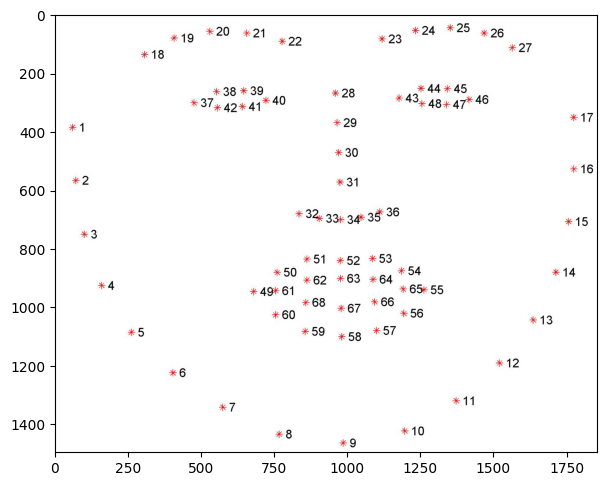

In [42]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

We randomly shuffle the data (even if it is not necessary for the TP)

In [43]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
np.random.shuffle(indeces)

X=Landmarks[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]] 


and we plot the first 6 (random) images with their respective landmarks

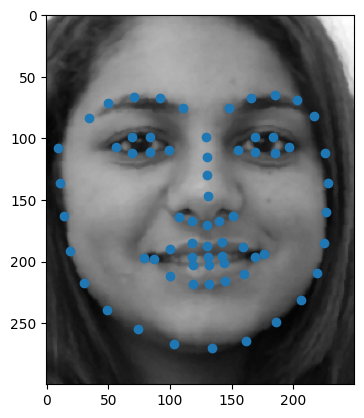

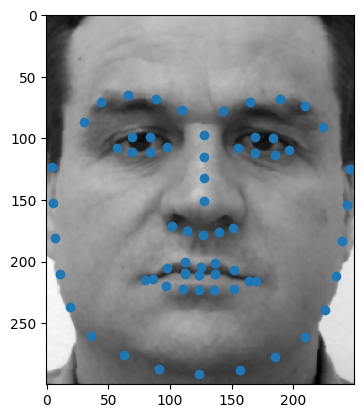

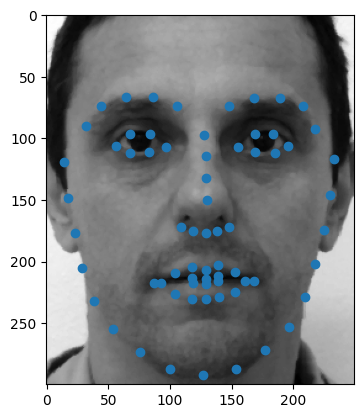

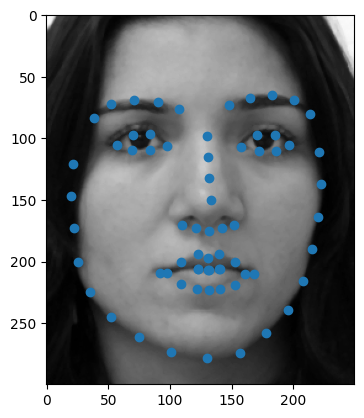

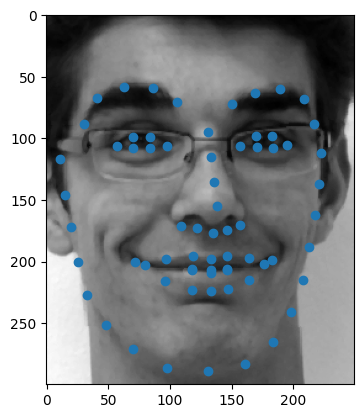

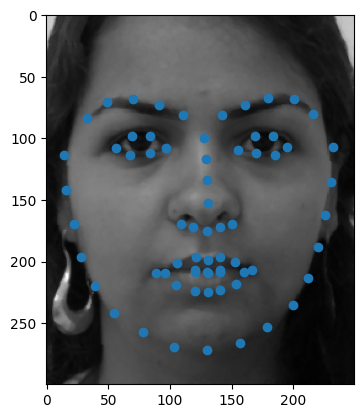

In [44]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

Now it's time to implement first the affine transformation and then the procrustes alignement (similarity transformation).
Please complete the code.

In [45]:
def AffineRegistrationLandmarks(x,y):

    '''
    Inputs:
               x: [M,2] array containing the M 2-dim source landmarks
               y: [M,2] array containing the M 2-dim target landmarks

    Outputs:
               xp: [M,2] array containing the M 2-dim aligned source landmarks
               T: [3,3] transformation matrix

    '''

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')

    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')

    M=x.shape[0]

    x_matrix = np.zeros((2*M, 6))
    x_matrix[0:M, 2] = 1
    x_matrix[0:M, 0:2] = x
    x_matrix[M:2*M, 5] = 1
    x_matrix[M:2*M, 3:5] = x

    y_vector = np.concatenate((y[:,0], y[:,1]))

    
    T_ols = np.linalg.inv(x_matrix.T @ x_matrix) @ x_matrix.T @ y_vector

    xp = (x_matrix @ T_ols)
    xp = np.vstack((xp[0:M], xp[M:2*M])).T

    
    T = np.vstack((T_ols.reshape((2,3)), np.array([0, 0, 1])))

    return xp,T


Let's test your implementation and see if it works.

[[ 9.07945971e-01  2.85345880e-03  8.93541098e+00]
 [-7.55726550e-03  9.73968976e-01 -1.45124991e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


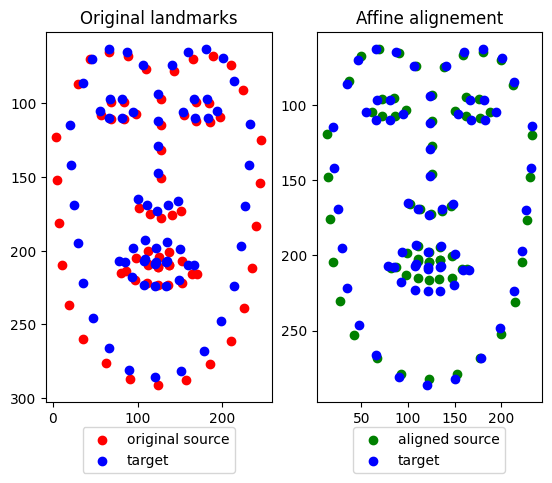

In [46]:
# Choose two random indeces between 0 and N-1
indexSource = 1
indexTarget = 7

# Choose if you want to plot data or not
show_plot=1

# Procrustes superimposition of two configurations    
ls = X[indexSource] # source configuration
Is = Imagesp[indexSource,:,:]
lt = X[indexTarget] # target configuration
It = Imagesp[indexTarget,:,:]

# reshape landmarks configurations as matrices [M,2]
xs=np.reshape(ls,(M,dim))
xt=np.reshape(lt,(M,dim))

xpA,TA=AffineRegistrationLandmarks(xs,xt)
print(TA)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xpA[:,0], xpA[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Affine alignement')

Now, let's implement the procrustes alignement following the inputs and rules explained in the header of the function. 

In [47]:
def procrustes_align(x,y,mode='best',verbose=1):

    """ 
    Inputs: 
               X: [M,2] array containing the M 2-dim source landmarks
               Y: [M,2] matrix containing the M 2-dim target landmarks
               mode: 'rotation' to have only rotation, 'reflection' to
                   have only reflection and 'best' to have the one decided by the
                   data depending on det(U*V')
               verbose: 1 to have explanations and 0 otherwise
    
    Outputs:
               Xp: [M,2] array containing the aligned source landmarks
               s: uniform scaling
               R: rotation or reflection matrix
               t: translation vector
               SSR: sum of squared of residuals
               ratio_SSR: ratio of SSR with respect to the initial SSR
    
    """
    
    if mode.lower()!='best' and mode.lower()!='rotation' and mode.lower()!='reflection':
        raise NameError('Error ! mode should be equal to best, rotation or reflection')   
    
    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    # Center data
    x_c = x- np.mean(x, axis=0)
    y_c = y- np.mean(y, axis=0)

    # Scale to equal unit size
    x_s = np.divide(x_c, np.abs(x_c).max())
    y_s = np.divide(y_c, np.abs(y_c).max())
#    normalized_vectors = []
#    for vector in x_c:
#        magnitude = np.linalg.norm(vector)
#        normalized_vector = vector / magnitude
#        normalized_vectors.append(normalized_vector)
#    
#    x_s = np.array(normalized_vectors)
#    normalized_vectors = []
#    for vector in y_c:
#        magnitude = np.linalg.norm(vector)
#        normalized_vector = vector / magnitude
#        normalized_vectors.append(normalized_vector)
#    
#    y_s = np.array(normalized_vectors)
        
    # Optimal parameters (hint: use np.linalg.svd)
    U, D, Vt = np.linalg.svd((x_s.T @ y_s))
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2) 
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection but a rotation is computed as requested.')               
            S=np.array([[1, 0], [0, np.linalg.det(U@Vt)]]) # to have det(U*V')=1
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation but a reflection is computed as requested.')               
            S=np.array([[1, 0], [0, -np.linalg.det(U@Vt)]]) # to have det(U*V')=-1
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'best':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
            
    R= ((U @ S) @ Vt)
    print(D)
    s= np.trace((S @ np.array([[D[0],0],[0,D[1]]])))/(np.linalg.norm(x_s,ord='fro')**2)
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(R)-1)>1e-5:
            raise NameError('Error ! there is a problem...')
    if mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(R)+1)>1e-5:
            raise NameError('Error ! there is a problem...')
            
    t = np.mean(y, axis=0) - (s*(R.T @ np.mean(x, axis=0)))

    xp=[]
    for i in x:
        xp.append(s*(R.T @ (i))+t)
    xp= np.array(xp)
    
    # Procrustes residuals
    SSR = np.sum(np.power((y-xp),2))
    
    # Ratio with initial residual
    SSR0 = np.sum(np.power((y-x),2))
    ratioSSR = SSR*100/SSR0
    
    return xp, s, R, t, SSR, ratioSSR

The best R is a rotation. Computing rotation.
[18.25195003 14.5363481 ]


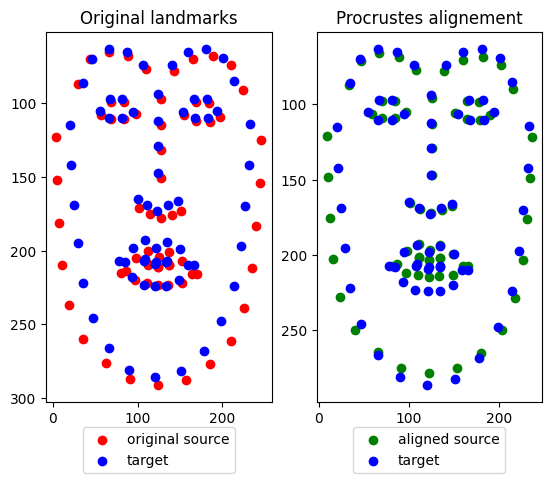

In [48]:
xp, s, R, t, SSR, ratioSSR = procrustes_align(xs,xt)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xp[:,0], xp[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Procrustes alignement')

**QUESTIONS**

*   What happens if you center the configurations before the alignment ?
*   When do you expect a perfect alignment ?



1. Centering plays a pivotal role by nullifying translations within configurations. Its significance becomes particularly pronounced when we seek to compare shapes while disregarding their positions within an image. By centering, we effectively strip away positional information, enabling alignment algorithms to concentrate on shape disparities rather than location specifics. This becomes crucial in numerous applications, especially in realms like facial recognition or medical image analysis, where shape takes precedence over position.

In methodologies like Procrustes Analysis, centering serves as a prerequisite for precisely calculating rotation and scaling components. It ensures that variations stemming from translation don't influence the analysis, allowing a more accurate examination and comparison of shapes. This step paves the way for a clearer understanding of the inherent shape differences without the interference of positional nuances.

When we center our configurations before the alignment we center all our data and so that we consider $t^*=0$

2. Perfect alignment, while ideal, may not always be achievable, but there are scenarios where we can get very close:

Identical Shapes: When source and target configurations share the same shape but differ in position, orientation, or scale, we can achieve near-perfect alignment by correcting these differences.

High-Quality Landmarks: The accuracy of landmark placement significantly influences alignment precision. When landmarks are consistently and precisely positioned on corresponding anatomical or structural points in both images, near-perfect alignment becomes more likely.

Sufficient and Relevant Landmarks: The number and distribution of landmarks play a crucial role. Having an ample number of landmarks covering key features and relevant structures in both configurations enhances the likelihood of achieving better alignment.

Absence of Non-linear Deformations: Linear methods like affine transformations or Procrustes Analysis work well when differences between configurations stem solely from linear transformations (translation, rotation, scaling). However, non-linear deformations such as bending or twisting pose challenges for perfect alignment using these linear methods. Achieving near-perfect alignment becomes more feasible when non-linear deformations are absent.

Now, using the functions implemented in the previous jupyter-notebook apply the transformation computed with the affine and/or procrustes alignement to the source image.

In [49]:
def nearestNeighboutInterp(pM,I,coords=None):
    ''' 
    Nearest Neighbout interpolation
        
    Inputs: 
        pM: 2D point defining the coordinates to interpolate
        I: image used for interpolation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
                    
    Output:
        value: interpolated value at pM
    ''' 
    
    if coords is None:
        coords = np.mgrid[0:I.shape[0], 0:I.shape[1]]
        # row and column of pM
        r = pM[0]
        c = pM[1]
        
        # check if r and c are within the domain of I (I.shape)
        if  (0 <= r < I.shape[0]-1) and (0 <= c < I.shape[1]-1):
                value = I[round(r)][round(c)]
        else:
            value=0
        
    else:
        raise ValueError("Error ! Still not implemented")
        value=0
    #print(value)
    return value


def InverseWarping(I,T,coords=None,outputShape=None):
    ''' 
    Apply inverse warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB', 
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)
        
            
    Output:
        J: transformed image
    ''' 
    
    if coords is None:
        coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates

        if outputShape is None:
            outputShape=(0,I.shape[0],0,I.shape[1])
            
        elif outputShape == 'BB':
            #Find extremities bounding box
            coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates
            cm = applyTransformation(T,coords=coords)[1]
            bx=int(np.floor(np.min(cm[0,:,:])))
            ux=int(np.ceil(np.max(cm[0,:,:])))
            by=int(np.floor(np.min(cm[1,:,:])))
            uy=int(np.ceil(np.max(cm[1,:,:])))
            outputShape=(bx,ux,by,uy)
            
        elif isinstance(outputShape, tuple):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")           
                
        elif isinstance(outputShape, np.ndarray):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")                                      
        else:
            raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")       
           
        J= np.zeros((outputShape[1]-outputShape[0],outputShape[3]-outputShape[2])) # transformed image
        for i in range(outputShape[1]-outputShape[0]):
            for j in range(outputShape[3]-outputShape[2]):

                p=[coords[0][i][j],coords[1][i][j],1] # coordinate of a pixel to transform
                pM = np.linalg.inv(T).dot(p) # transformed coordinate

                if pM[-1] != 0: 
                  pM = [pM[0]/pM[2],pM[1]/pM[2]] # normalization in case of homography

                  # shifting since the first pixel will be in (0,0) in the output image
                  if outputShape[0]<0:
                      x=i+abs(outputShape[0])
                  else:
                      x=i
                  if outputShape[2]<0:
                      y=j+abs(outputShape[2])
                  else:
                      y=j
                      
                  J[x,y]=nearestNeighboutInterp(pM,I)
    
    else:
        raise ValueError("Error ! Still not implemented") 
    return J

In [50]:
def applyTransformation(T, points=None, coords=None):
    ''' 
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        points: Nx2 Numpy array of points 
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation
            
    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    ''' 
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")
    
    if points is not None:    
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape
            
        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")

        points = list(points)
    
        for i in range(len(points)):
            points[i] = np.append(points[i], 1)
    
        # Apply transformation
        for i in range(len(points)):
            points[i] = np.dot(T,np.transpose(points[i]))
    
        
        # If homography, ...
        if (T[2,0] != 0) or (T[2,1] != 0):
            points = np.array([[x/z,y/z,1] for [x,y,z] in points])
        pm=np.array(points)
    else:
        pm=None
        
    if coords is not None:
        d,N,M = coords.shape
        
        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")
        coords = coords.reshape((2,N*M)).T # reshape coordinates as list of points
        # Transform points into homogeneous coordinates (adding one...)
        coords = list(coords)
        #print(coords)
        for i in range(len(coords)):
            coords[i] = (np.append(coords[i], 1))
        # Apply transformation
        for i in range(len(coords)):
            coords[i] = (np.dot(T,np.transpose(coords[i])))
        #print('now changed')
        #print(coords)
        # If homography, ...
        if (T[2,0] != 0) or (T[2,1] != 0):
            coords = np.array([[x/z,y/z,1] for [x,y,z] in coords])
        for i in range(len(coords)):
            coords[i] = np.array([coords[i][0],coords[i][1]])
        pm=np.array(coords)
        #print('final result')
        #print(pm)
        cm = pm.T.reshape((2,N,M))
        #print('final final result')
        #print(cm)

    else:
        cm =None
                
    return pm,cm

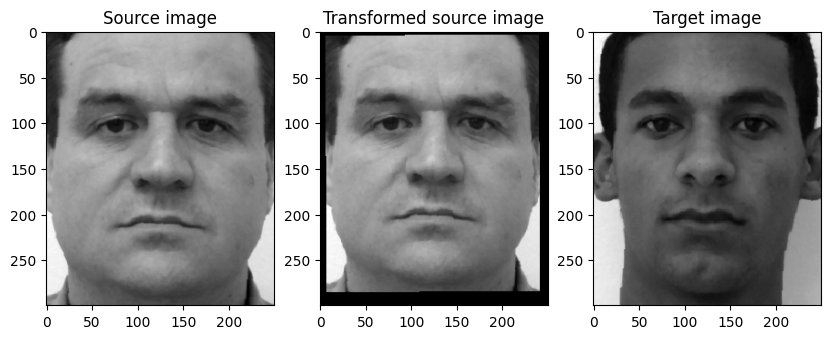

In [51]:
# compute T       
T = np.array([
            [s*R[0,0], s*R[0,1], t[0]],
            [s*R[1,0], s*R[1,1], t[1]],
            [0, 0, 1]
            ])
    
Ism=InverseWarping(Is,T,outputShape=None)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(It, cmap='gray')
ax3.set_title('Target image')
plt.show() 

Now let's implement the Generalized Procrustes Analysis (GPA) using the previously implemented procrustes alignement function.

As before, please follow the inputs and rules explained in the header of the function.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def generalized_procrustes_analysis(X, tau=1e-5, tangent=1):
    """
    Inputs: 
        X: [N,2M] array containing N configurations of 2D landmarks. 
           Each configuration has M landmarks
        tau: parameter for the stopping criteria (please refer to the slides 
             of the course)
        tangent: if set to 1, data will be projected onto the tangent space

    Outputs: 
        Xm1: [M,2] array containing the landmarks of the average configuration
        Xcp: [N,2M] array containing the aligned landmarks onto Xm1
    """

    if X.shape[1] % 2 != 0:
        raise NameError('This code works only for 2-dimensional data')

    # Parameters
    N, M = X.shape
    dim = 2
    M = int(M / dim)

    # Plot original data
    plt.figure()
    for i in range(0, N):
        landmark = X[i]
        x = landmark[::2]
        y = landmark[1::2]
        plt.scatter(x, y, c='r')
    plt.gca().invert_yaxis()
    plt.title('Original landmarks')

    # Center each configuration
    Xc = np.zeros((N, M * dim))
    for i in range(0, N):
        Xc[i][::2] = X[i][::2] - np.mean(X[i][::2])
        Xc[i][1::2] = X[i][1::2] - np.mean(X[i][1::2])

    # Compute first average configuration
    Xm0 = np.mean(Xc, axis=0)

    # Plot configurations and first average
    plt.figure()
    for i in range(0, N):
        landmark = Xc[i]
        x = landmark[::2]
        y = landmark[1::2]
        plt.scatter(x, y, c='r')
    plt.scatter(Xm0[::2], Xm0[1::2], c='g', label='average')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().invert_yaxis()
    plt.title('Centered data with first average')

    #Normalize average
    Xm0_norm = np.linalg.norm(Xm0)
    Xm0 = Xm0 / Xm0_norm
    for i in range(0, N):
        Xc[i] = Xc[i]/Xm0_norm

    # Procrustes alignment of all configurations to the average Xm0
    Xcp = np.zeros((N, M * dim))
    for i in range(0, N):
        temp = Xc[i].reshape(M, dim)
        xp, s, R, t, SSR, ratioSSR = procrustes_align(temp, Xm0.reshape(M, dim), 'best', 0)
        Xcp[i] = xp.flatten()

    # Reshape average as vector
    Xm0 = Xm0.flatten()

    # Plot configurations and average
    plt.figure()
    for i in range(0, N):
        landmark = Xcp[i]
        x = landmark[::2]
        y = landmark[1::2]
        plt.scatter(x, y, c='r')

    plt.scatter(Xm0[::2], Xm0[1::2], c='g', label='average')
    plt.gca().invert_yaxis()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Aligned data to normalized initial mean')

    # Tangent space projection
    if tangent == 1:
        # landmarks after tangent space projection
        Xcpt = np.zeros((N, M * dim))
        # vector measuring the difference before/after projection
        diff = np.zeros((N, 1))

        for i in range(0, N):
            Xcpt[i] = (Xcp[i] / np.linalg.norm(Xcp[i])) - ((Xcp[i] / np.linalg.norm(Xcp[i])) * Xm0) * Xm0
            diff[i] = np.linalg.norm(Xcp[i] - Xcpt[i])

        # we look for the subject with the maximum difference before/after projection
        ind = np.argmax(diff)

        # Plot configurations and first average
        plt.figure()
        l = Xcp[ind]
        lt = Xcpt[ind]
        plt.scatter(l[::2], l[1::2], c='r', label='before projection')
        plt.scatter(lt[::2], lt[1::2], c='b', label='after projection')
        plt.gca().invert_yaxis()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Subject with maximum variation')

        plt.figure()
        for i in range(0, N):
            landmark = Xcp[i]
            x = landmark[::2]
            y = landmark[1::2]
            if i == ind:
                plt.scatter(x, y, c='b', label='Subject with max distortion', zorder=10)
            else:
                plt.scatter(x, y, c='r')

        plt.scatter(Xm0[::2], Xm0[1::2], c='g', label='average', zorder=5)
        plt.gca().invert_yaxis()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Subjects before projection')

        Xcp = Xcpt

    # Re-estimate average configuration
    Xm1 = np.mean(Xcp, axis=0)

    # Procrustes alignment of Xm1 to Xm0
    Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1, (M, dim)), np.reshape(Xm0, (M, dim)), 'best', 0)

    # Scale to unit size new average Xm1
    Xm1 = Xm1 / np.linalg.norm(Xm1)

    # Reshape average as vector
    Xm1 = Xm1.flatten()

    # Plot configurations and new average
    plt.figure()
    for i in range(0, N):
        landmark = Xcp[i]
        x = landmark[::2]
        y = landmark[1::2]
        plt.scatter(x, y, c='r')

    plt.scatter(Xm1[::2], Xm1[1::2], c='g', label='average')
    plt.gca().invert_yaxis()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Aligned data to new mean')

    itera = 1
    while np.sqrt(np.dot((Xm0 - Xm1), (Xm0 - Xm1))) > tau:
        print('Iter number %d , Error: %f' % (itera, np.sqrt(np.dot((Xm0 - Xm1), (Xm0 - Xm1)))))
        itera = itera + 1

        # Update Xm0 to Xm1
        Xm0 = Xm1

        # Procrustes alignment of all configurations to the average Xm0
        for i in range(0, N):
            temp = np.reshape(Xc[i], (M, dim))
            xp, s, R, t, SSR, ratioSSR = procrustes_align(temp, np.reshape(Xm0, (M, dim)), 'best', 0)
            Xcp[i] = np.reshape(xp, (M * dim))

        # Tangent space projection
        if tangent == 1:
            for i in range(0, N):
                Xcp[i] = (Xcp[i] / np.linalg.norm(Xcp[i])) - ((Xcp[i] / np.linalg.norm(Xcp[i])) * Xm0) * Xm0

        # Re-estimate average configuration
        Xm1 = np.mean(Xcp, axis=0)

        # Procrustes alignment of Xm1 to Xm0
        Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1, (M, dim)), np.reshape(Xm0, (M, dim)), 'best', 0)

        # Scale to unit size new average Xm1
        Xm1 = Xm1 / np.linalg.norm(Xm1)

        # Reshape average as vector
        Xm1 = np.reshape(Xm1, (M * dim))

        # Plot configurations and new average
        plt.figure()
        for i in range(0, N):
            landmark = Xcp[i]
            x = landmark[::2]
            y = landmark[1::2]
            plt.scatter(x, y, c='r')

        plt.scatter(Xm1[::2], Xm1[1::2], c='g', label='average')
        plt.gca().invert_yaxis()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('GPA results after iter %i' % itera)

    return Xcp, Xm1


In [53]:
#test = X
#print(test)
#print(X[0][::2])
#print(X[0][1::2])
#print(np.mean(test[0][::2]))
#print(np.mean(test[0][1::2]))
#test[0][::2] = test[0][::2] - np.mean(test[0][::2])
#test[0][1::2] = test[0][1::2] - np.mean(test[0][1::2])
#print(test)

Let's test your implementation and see if it works.

[17.05592377 14.8145685 ]
[18.31169683 15.23281067]
[18.28387036 13.65098784]
[18.50542743 14.19920953]
[17.40807626 13.68678012]
[18.45371843 14.85242294]
[19.36128983 15.25892491]
[17.85014758 13.8131645 ]
[17.62530466 14.81723109]
[18.09328312 15.26740625]
[18.0124962  14.79535061]
[18.10628179 14.64084856]
[19.21732188 15.86358143]
[18.57611369 15.66073016]
[18.34652961 15.10036434]
[17.57873605 13.2602622 ]
[17.02820005 14.02371013]
[17.13181132 15.00193177]
[18.10691253 13.88372652]
[17.79694602 14.39708682]
[17.52526358 14.40561458]
[18.19879742 14.69881174]
[18.47708575 14.28091101]
[16.88287634 14.56241896]
[18.49362415 14.87318466]
[17.79681062 13.82083072]
[17.25714477 14.11462904]
[18.31167749 14.09426264]
[17.52150709 14.08255529]
[17.40647467 13.87603901]
[18.92972445 14.77011114]
[18.47439925 14.26604273]
[18.16073556 14.91444658]
[18.40014687 13.85940562]
[17.73152802 13.23221433]
[18.33309305 14.76181408]
[18.43244337 13.58916569]
[17.33576132 15.04887193]
[18.31080357

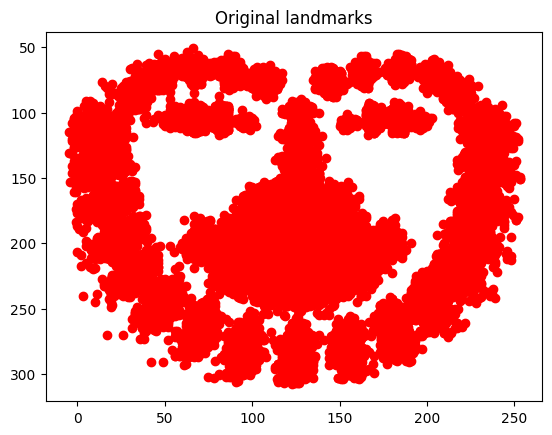

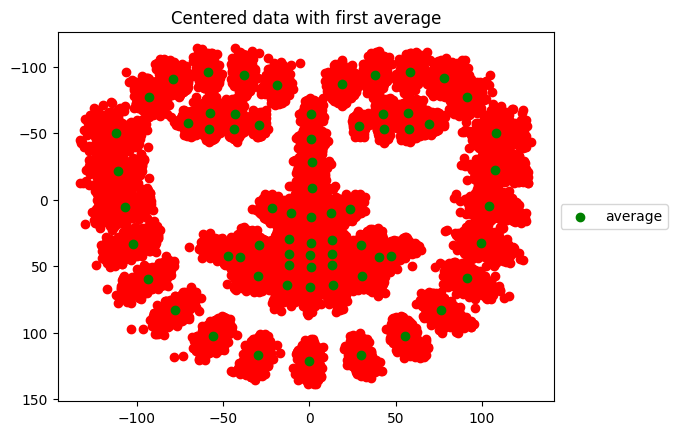

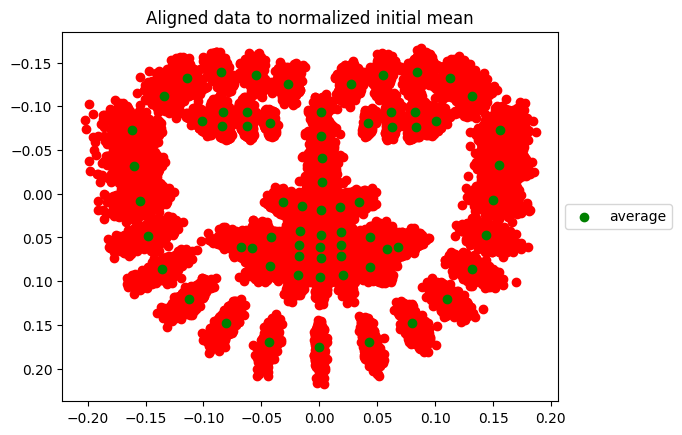

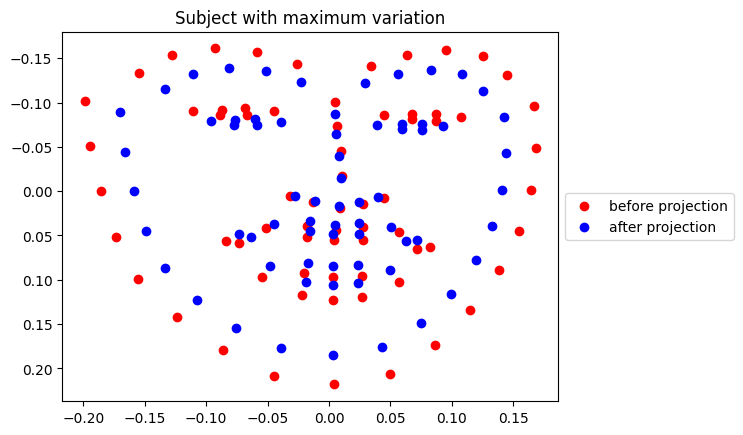

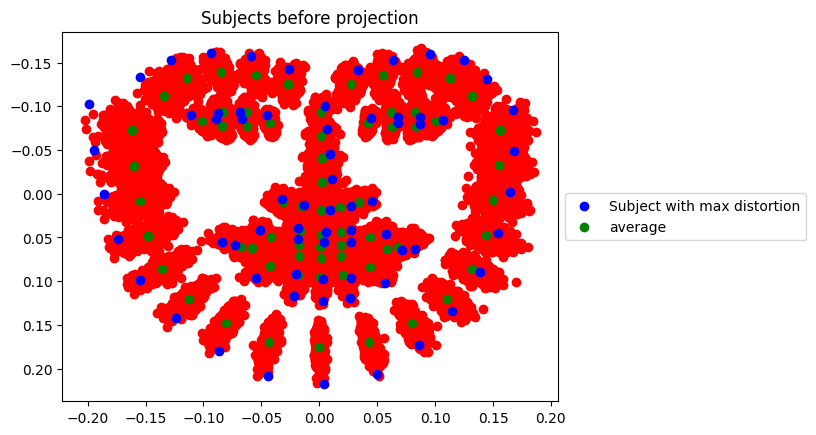

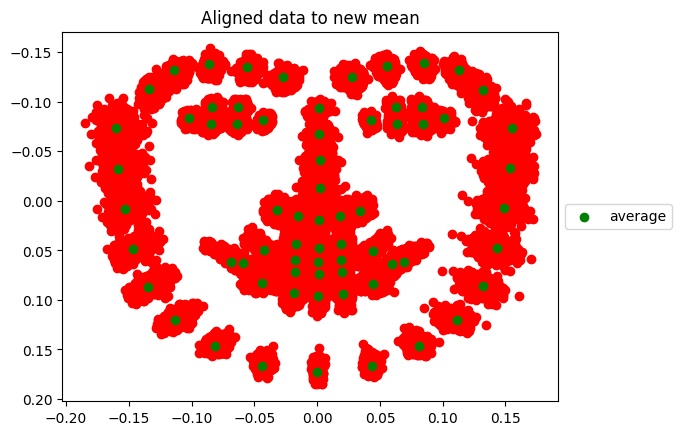

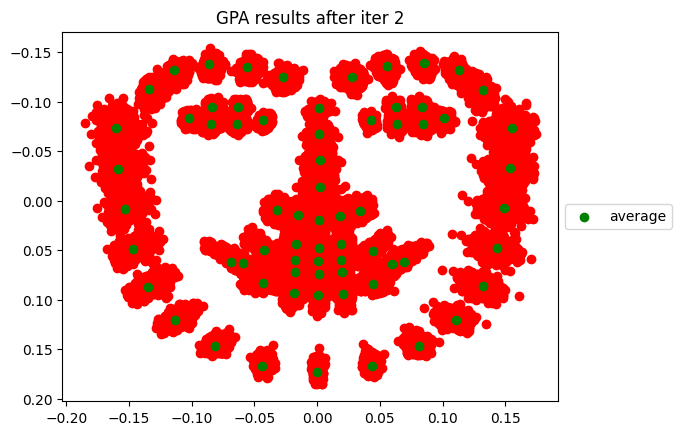

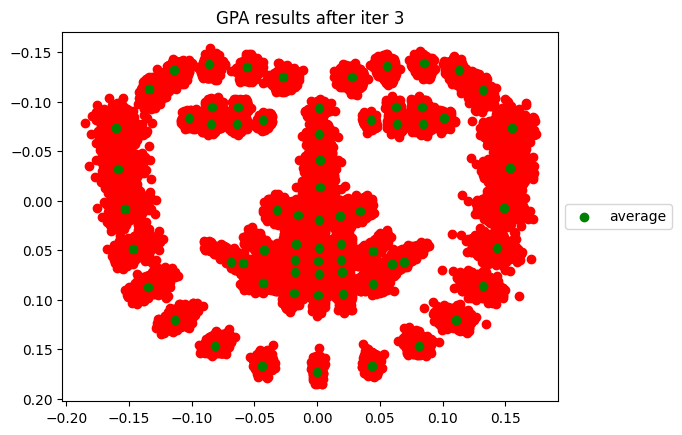

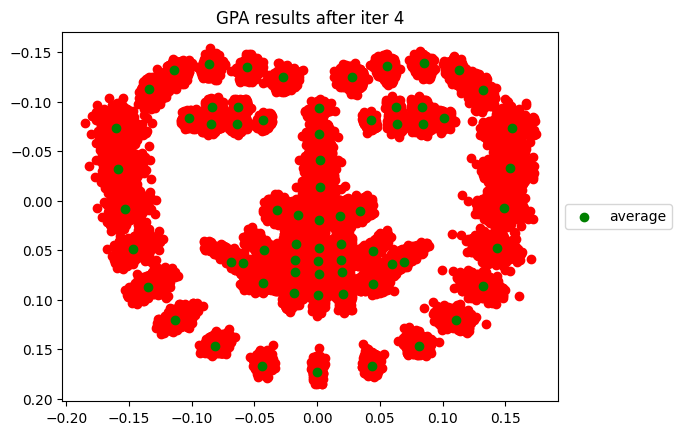

In [58]:
#  GPA (Generalized Procrustes Analysis)
Xcp, Xm1  = generalized_procrustes_analysis(X)   

**QUESTIONS**


*   Try not to project the data onto the tangent space (i.e. `tangent=0`). Do the results vary ? Why in your opinion ? Hint: Look at the variability of the original data...
*   Do the following four triangles have the same shape ? Explain why ?

![shape.png](https://drive.google.com/uc?id=10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L)

**Answers**
1. When performing Generalized Procrustes Analysis (GPA), there's a step called "tangent space projection" that's optional but quite impactful. When tangent=0, it means we're skipping this particular step:

Non-linear Shape Space: Shapes inherently exist in a non-linear space. By skipping the projection onto the tangent space, we might miss an opportunity to address this non-linearity. This omission could potentially result in a less accurate representation of the mean shape.
Data Variability Impact: When the original shapes vary significantly, neglecting the tangent space could lead to the mean shape being heavily influenced by extreme or distant configurations. The tangent space projection acts as a normalizer, placing shapes in a common linear space where their distances and variances are more balanced.
Geodesic Distances vs. Euclidean Distances: In shape spaces, the distances between shapes (geodesic distances) can differ from the typical straight-line Euclidean distances. The tangent space projection approximates these geodesic distances as Euclidean ones, which are easier to minimize accurately during GPA.
When there's substantial variability in the initial data and we don't use tangent projection, it can lead to the mean shape not fully representing the entire dataset. You might notice more diversity in the aligned shapes if this step isn't employed.

2. When we talk about shapes, we're considering how one figure can be transformed or changed to match another. If you can move, turn, or resize one shape to exactly match another, we say they have the same shape. In the case of triangles, if you can change one triangle to match another by sliding it, spinning it around, or making it bigger or smaller, then they have the same shape.

Now, similarity between triangles means they have the same shape but might not be exactly the same in size or orientation. For example, the first and third triangles in your sequence have the same shape because you can rotate the third one and make it bigger or smaller to look just like the first one. However, they may not have the same size or orientation.

The second triangle is similar in size to the first one, but a simple rotation won't make it match the first triangle. To make them identical, you'd need to reflect it across the y-axis (like flipping it over), which isn't just a rotation.

As for the last triangle, it's different. It doesn't have the same angles or proportions as the others, and you can't change its shape to exactly match the others by sliding, rotating, or resizing it. It's a unique shape that isn't transformable to match the others in the sequence.



Let's compute the shape variability using PCA. You will compute the three modes of deformations, as described in the slides of the lecture, at $\pm 3 \sigma$, where $\sigma$ is the standard deviation thus the square root of the the relative eigenvalue 

The first three modes explain 29.864501, 25.264187 and 12.397654 of the total variability respectively


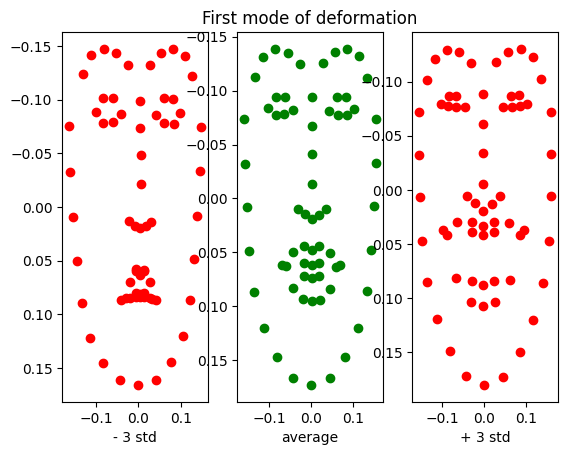

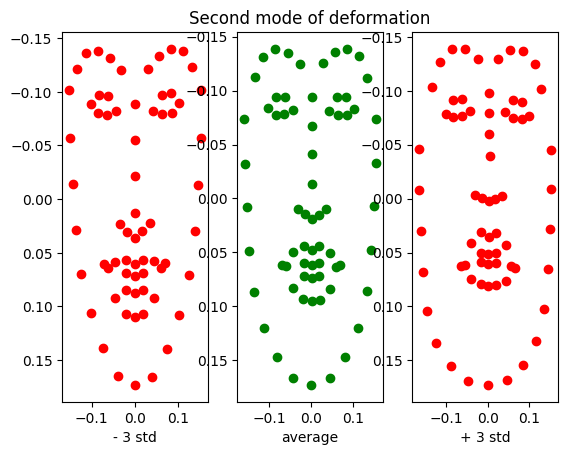

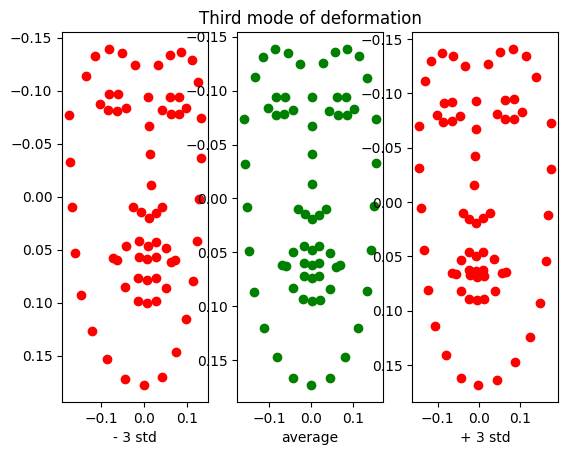

In [55]:
#%% Shape variability analysis
# we will use the scikit-learn implementation for PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y=pca.fit_transform(Xcp)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues
var_explained = pca.explained_variance_ratio_*100 # variance explained

print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2]))

# Compute first mode
first_mode_m = Xm1 - 3 * U[:, 0] * np.sqrt(D[0]) 
first_mode_p = Xm1 + 3 * U[:, 0] * np.sqrt(D[0]) 

# Compute second mode
second_mode_m = Xm1 - 3  * U[:, 1] * np.sqrt(D[1])
second_mode_p = Xm1 + 3  * U[:, 1] * np.sqrt(D[1])

# Compute third mode
third_mode_m = Xm1 - 3 * U[:, 2] * np.sqrt(D[2]) 
third_mode_p = Xm1 + 3 * U[:, 2] * np.sqrt(D[2]) 

if show_plot==1:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('First mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('Second mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r')
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average')
    plt.title('Third mode of deformation')
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 3)
    plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std')
    plt.gca().invert_yaxis()

**QUESTIONS**


*   How many modes do you need to explain 90% of the variability ?
*   Which anatomical variability do the first three modes show ? Was it expected ?
*   How could you check whether they show an anatomically plausible deformation ? 
*   Let's say that the anatomical deformation is not anatomically plausible, which kind of deformation would you use instead ? Why ?




In [56]:
explanation = np.cumsum(var_explained)
modes = np.argmax(explanation > 90)


print("Number of nodes: ", modes + 1)
print("Percentage of variability explained: ", explanation[modes])

Number of nodes:  9
Percentage of variability explained:  91.30100032185507


1. To figure out how many modes (or components) are necessary to cover 90% of the variability, we analyze the cumulative sum of the explained variance ratios. The 'var_explained' variable in the code holds the percentage of variance that each principal component accounts for. By using a function that sums these percentages successively, we determine the point where the accumulated sum hits or surpasses 90%. This helps us identify the number of modes needed to capture that significant portion of variability in the data. Answer: 9 modes

2. In facial analysis, the first three modes often showcase the primary sources of anatomical variability in a dataset:

The first mode tends to reflect general size differences or scaling variations among faces.
The second mode usually highlights changes in width or height across facial features.
The third mode captures more nuanced details like the curvature of specific facial parts or differences in angles.

3.  To verify the anatomical validity of deformations, several methods can be employed:

Visual Inspection: Experts can visually examine the deformations to evaluate their credibility and conformity to anatomical norms.

Biomechanical Modeling: Employing biomechanical models helps in assessing whether the observed deformations are feasible within the limitations imposed by human tissue and bone structure.

Statistical Tests: Comparing these deformations against a population model is another approach. If the observed alterations align within the usual spectrum found in a healthy population, they are likely considered anatomically plausible.

4. When faced with deformations that aren't anatomically plausible, alternative models can be explored:

Physically-based or Biomechanical Models: These models consider the physical characteristics of tissues, allowing predictions of deformations that align with realistic biomechanical behavior.

Statistical Shape Models with Constraints: Implementing constraints rooted in anatomical knowledge prevents the model from generating shapes that defy anatomical possibilities, thus maintaining plausibility.

Nonlinear Models: Linear PCA might struggle to capture nonlinear variations adequately. Techniques like Kernel PCA or other nonlinear dimensionality reduction methods can offer more suitable models for intricate, non-linear anatomical variations.

The choice of which model to employ hinges on the specific anatomical context and the nature of the implausible deformations observed. The objective is to opt for a model that upholds the underlying biological, anatomical, and physical constraints while effectively encapsulating the observed variation in the dataset.